# NBA Salary Prediction


<img src='https://www.mercurynews.com/wp-content/uploads/2020/03/BNG-L-WARRIORS-0306-7.jpg?w=525' style='float: center'>



## Problem Statement: 
Over the past few years, NBA players have received large contracts -around 40 million usd annual -as compared to those in the 2000s, where the highest salary was 20 million USD. Are the players today overpaid? In addition, Power Forwards or Centers, positions that were previously known for dominating in the paint, are developing a 3-point shot. In fact, the players have evolved from those who were unstoppable in mid-range and inside the paint (Shaquille O'Neal, Kevin Garnett, Tim Duncan) to those with an outside touch (Karl-Anthony Towns, Anthony Davis, Kristap Porzingis). 

Is this a requirement to be able to succeed in today's game? 


## Objective:
I am looking to predict the expected salary of a player based from his performance the past year and the historical dataset for the past 20 years. I believe there is a correlation between a player's performance and the contract they have, but there should be certain stats (features) that have a stronger correlation than others. 

## Assumptions:

Players are accepting the largest contract they are offered by teams, instead of leaving money on the table. 
I am looking how well they perform on average per game from past last season.

## Notes:

Rookies' contracts are not included in this dataset, as they do not have participated in NBA games yet. 

### Steps Guide:
- [Web Scraping](./WebScraping.ipynb)
- [Cleaning Data](#data-cleaning)
- [Machine Learning Models](#machine-learning) 
 - [Linear Regression](#linear-regression)
 - [Random Forest Regression](#random-forest-regression)
 - [XGBoost Regression](#XGBoost-regression)
 - [Conclusion](#Conclusion)

<a id="data-cleaning"></a>
## Cleaning the Data
--- 

####  Combine the salary csv with the stats csv, and perform necessary changes.

In [28]:
#Import the necessary modules for the whole notebook
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import cpi
import xgboost as xgb
from matplotlib.ticker import MaxNLocator
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn import model_selection
from sklearn import metrics
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
%matplotlib inline


plt.rcParams['figure.figsize'] = (15,6)
plt.rcParams['font.size'] = 14

In [29]:
#Create Salary and Stats dataframe
salary = pd.read_csv('./data/salary.csv')
stats = pd.read_csv('./data/stats.csv')

In [30]:
#Change those with special characters
#Drop duplicates, for those were traded midway.
stats = stats.drop_duplicates(['Player','Year'],keep='first',ignore_index=True) #Drop duplicates.
stats['Player']=stats['Player'].str.replace('*','')#remove the asterisk
stats['Player']=stats['Player'].str.replace('ć','c')#remove special characters
stats['Player']=stats['Player'].str.replace('č','c')
stats['Player']=stats['Player'].str.replace('á','a')
stats['Player']=stats['Player'].str.replace('.','')

#show salary in terms of millions.
salary.Salary = salary.Salary/1000000

#### Calculation Inflation Rate

In [31]:
#Account for inflation by using CPI Method

def inflate(salary,year):
    if year == 2020:
        return salary
    elif year == 2019:
        return salary * 1.023
    else:
        return cpi.inflate(salary,year)

def inflation_column(df,column):
    """
    Adjust for inflation the series of values in column of the   
    dataframe data
    """
    return df.apply(lambda x: inflate(x[column],x.Year),axis=1)



salary['Salary'] = inflation_column(salary,'Salary')

#Verification
# salary[salary.Player.str.contains('Shaq')]
# salary[salary.Player.str.contains('Rudy Gobert')]

In [32]:
salary.sample(n=10)

,Player,Year,Salary
5637,Marvin Williams,2012,9.064040
7789,Kris Dunn,2016,4.051619
9387,Markelle Fultz,2019,9.969340
5964,Draymond Green,2012,0.929645
4577,Shelden Williams,2009,0.966211
8218,Alec Burks,2017,11.110405
6501,Ian Clark,2013,0.528371
4813,Nikola Pekovic,2010,4.606285
2021,Chris Kaman,2004,3.421968
2541,Vlade Divac,2005,2.571500


In [35]:
#Ensure no null/missing values
salary.isnull().sum()

Player    0
Year      0
Salary    0
dtype: int64

#### Let's check Steph Curry's stats!

In [36]:
#Verification
stats[stats['Player'].str.contains('Stephen Curry')]

,Player,Year,POS,Age,TM,GP,GS,MP,FGM,FGA,...,FT%,ORB,DRB,REB,AST,STL,BLK,TOV,PF,PTS
4563,Stephen Curry,2010,PG,21,GSW,80,77,36.2,6.6,14.3,...,0.885,0.6,3.9,4.5,5.9,1.9,0.2,3.0,3.2,17.5
5007,Stephen Curry,2011,PG,22,GSW,74,74,33.6,6.8,14.2,...,0.934,0.7,3.2,3.9,5.8,1.5,0.3,3.1,3.1,18.6
5459,Stephen Curry,2012,PG,23,GSW,26,23,28.2,5.6,11.4,...,0.809,0.6,2.8,3.4,5.3,1.5,0.3,2.5,2.4,14.7
5932,Stephen Curry,2013,PG,24,GSW,78,78,38.2,8.0,17.8,...,0.900,0.8,3.3,4.0,6.9,1.6,0.2,3.1,2.5,22.9
6414,Stephen Curry,2014,PG,25,GSW,78,78,36.5,8.4,17.7,...,0.885,0.6,3.7,4.3,8.5,1.6,0.2,3.8,2.5,24.0
6896,Stephen Curry,2015,PG,26,GSW,80,80,32.7,8.2,16.8,...,0.914,0.7,3.6,4.3,7.7,2.0,0.2,3.1,2.0,23.8
7381,Stephen Curry,2016,PG,27,GSW,79,79,34.2,10.2,20.2,...,0.908,0.9,4.6,5.4,6.7,2.1,0.2,3.3,2.0,30.1
7850,Stephen Curry,2017,PG,28,GSW,79,79,33.4,8.5,18.3,...,0.898,0.8,3.7,4.5,6.6,1.8,0.2,3.0,2.3,25.3
8358,Stephen Curry,2018,PG,29,GSW,51,51,32.0,8.4,16.9,...,0.921,0.7,4.4,5.1,6.1,1.6,0.2,3.0,2.2,26.4
8902,Stephen Curry,2019,PG,30,GSW,69,69,33.8,9.2,19.4,...,0.916,0.7,4.7,5.3,5.2,1.3,0.4,2.8,2.4,27.3


#### Combine both the salary and stats dataframe.

In [38]:
df = pd.merge(salary,stats,on=['Player','Year'],how='left')
df.shape

(10319, 30)

In [39]:
#Drop the values with NA, as most of them are rookies with contracts.
df=df.dropna(axis='rows').reset_index(drop=True)

In [40]:
#Check for null values that resulted from our join method.
df.isnull().sum()

Player    0
Year      0
Salary    0
POS       0
Age       0
TM        0
GP        0
GS        0
MP        0
FGM       0
FGA       0
FG%       0
3PM       0
3PA       0
3P%       0
2PM       0
2PA       0
2P%       0
FTM       0
FTA       0
FT%       0
ORB       0
DRB       0
REB       0
AST       0
STL       0
BLK       0
TOV       0
PF        0
PTS       0
dtype: int64

#### Many dual positions, so we only take the 1st, as this was their original position at the start of the season before they got traded.

In [45]:
df['POS'].value_counts()

SG    1594
PG    1457
SF    1382
PF    1360
C     1010
Name: POS, dtype: int64

In [46]:
df['POS']=df['POS'].str.split("-",expand=True)[0]
df['POS'].value_counts()

SG    1594
PG    1457
SF    1382
PF    1360
C     1010
Name: POS, dtype: int64

In [47]:
# mean salaries is in millions.
df.groupby(['Year','POS'])['Salary'].agg(['mean']) 

mean
Year POS           
2000 C     9.298772
     PF    7.549561
     PG    4.681793
     SF    5.077988
     SG    5.343863
...             ...
2020 C     7.960117
     PF    8.786709
     PG   11.947412
     SF    7.834022
     SG    7.181959

[105 rows x 1 columns]

#### Plot the average salary for each position throughout the years.

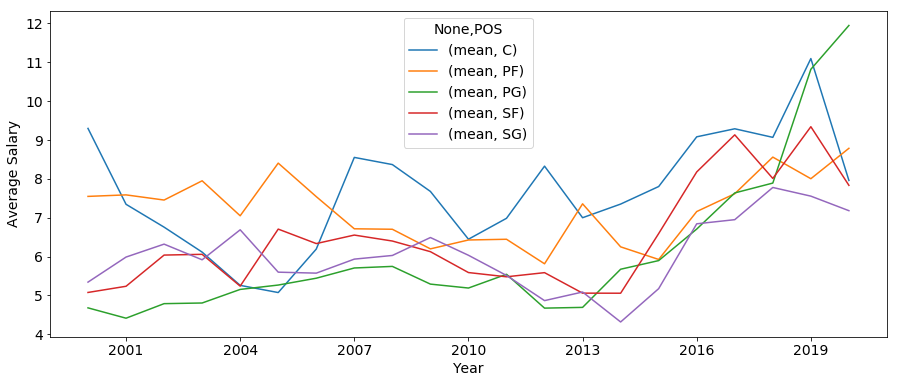

In [48]:
fig, ax = plt.subplots(figsize=(15,6));


df.groupby(['Year','POS'])['Salary'].agg(['mean']).unstack().plot(ax=ax,kind='line');
ax.xaxis.set_major_locator(MaxNLocator(integer=True)) #set xticklabel to integer.

#Try to make hover show the values as well.
ax.set_xlabel("Year");
ax.set_ylabel("Average Salary");

#### Findings:
PG Salary ranked from lowest in 2000 to highest in 2020.<br>
C Salary ranked from highest in 2000 to close to bottom in 2020. 

#### Let's check the average 3 pointers made for each position as well.

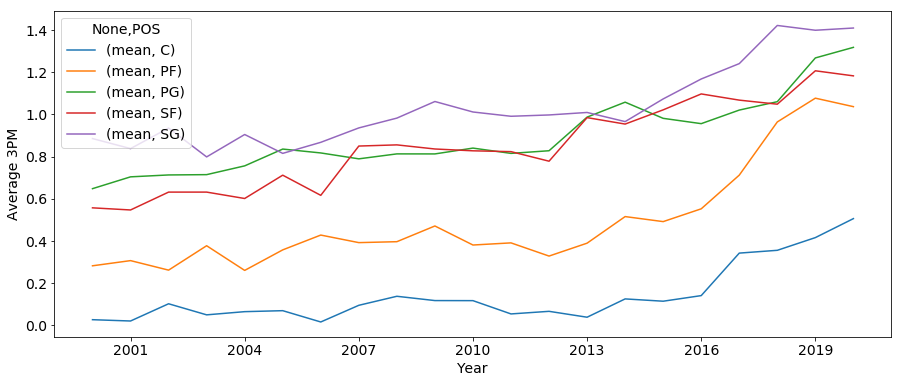

In [50]:
from matplotlib.ticker import MaxNLocator

fig, ax = plt.subplots(figsize=(15,6));
df.groupby(['Year','POS'])['3PM'].agg(['mean']).unstack().plot(ax=ax,kind='line');
ax.xaxis.set_major_locator(MaxNLocator(integer=True)) #set xticklabel to integer.
ax.set_xlabel("Year");
ax.set_ylabel("Average 3PM");

#### Findings:
The average salary of Point Guards dramatically increased from 2000.<br>
The average salary of Centers was ranked one of the highest in early 2000, but seen a sharp decrease in 2019.

## Machine Learning Models
<a id="machine-learning"></a>

Even though we have data starting from 2000, multiple dynamics have changed - 3 pointers have become more apparent.<br>
Fewer people are attempting mid-range jumpshots.<br>
Thus, I will use the past 5 years' dataset to predict the salary using 3 machine learning models.

#### Create a dataframe for the past 5 years.

In [51]:
#Create a recent years dataframe.
lastfiveyears_df=df[df.Year>=2015]

#### Since there are many confounding variables between one another, let's include the basic stats that dictate a player's performance:
FG%, FT%, 3PM, PTS, REB,AST,STL,BLK,TOV,PF

In [73]:
lastfiveyears_df
#lastfiveyears_df.drop(['GS','FGA','FGM','3PA','2PA','2P%','FTA','ORB','DRB','2PM','MP'],axis=1,inplace=True)

,Player,Year,Salary,POS,Age,TM,GP,GS,MP,FGM,...,FT%,ORB,DRB,REB,AST,STL,BLK,TOV,PF,PTS
4659,Kobe Bryant,2015,26.486180,SG,36.0,LAL,35.0,35.0,34.5,7.6,...,0.813,0.7,4.9,5.7,5.6,1.3,0.2,3.7,1.9,22.3
4660,LeBron James,2015,24.336032,SF,30.0,CLE,69.0,69.0,36.1,9.0,...,0.710,0.7,5.3,6.0,7.4,1.6,0.7,3.9,2.0,25.3
4661,Carmelo Anthony,2015,24.234855,SF,30.0,NYK,40.0,40.0,35.7,9.0,...,0.797,1.8,4.8,6.6,3.1,1.0,0.4,2.2,2.2,24.2
4662,Dwight Howard,2015,23.688566,C,29.0,HOU,41.0,41.0,29.8,6.1,...,0.528,2.7,7.8,10.5,1.2,0.7,1.3,2.8,3.3,15.8
4663,Joe Johnson,2015,23.635572,SG,33.0,BRK,80.0,80.0,34.9,5.6,...,0.801,0.7,4.1,4.8,3.7,0.7,0.2,1.7,1.5,14.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6798,Quinndary Weatherspoon,2020,0.079568,SG,23.0,SAS,11.0,0.0,7.1,0.5,...,0.500,0.1,0.5,0.6,1.0,0.3,0.1,0.5,0.7,1.1
6799,Yuta Watanabe,2020,0.079568,SF,25.0,MEM,18.0,0.0,5.8,0.8,...,0.375,0.4,0.7,1.1,0.3,0.3,0.1,0.1,0.5,2.0
6800,Jarrell Brantley,2020,0.079568,PF,23.0,UTA,9.0,0.0,10.7,1.1,...,0.500,0.2,2.0,2.2,1.2,0.3,0.6,0.8,0.8,2.7
6801,Garrison Mathews,2020,0.079568,SG,23.0,WAS,18.0,0.0,12.6,1.3,...,0.912,0.3,1.0,1.3,0.6,0.4,0.1,0.4,1.8,5.4


### 1. Linear Regression Model: 
<a id="linear-regression"></a>
We will use the 10 basic indicators, and set it as our feature column.

In [104]:
#Create a list of features
feature_cols=['PTS','FG%','FT%','3PM','AST','REB','STL','BLK','TOV','PF']

#### Apply feature scaling.

In [105]:
#Feature Scaling
scaler = StandardScaler()
X = lastfiveyears_df[feature_cols]
X = scaler.fit_transform(X)
y = lastfiveyears_df.Salary

#### Preliminary Linear Regression Model

Do a Train Test Split with size 0.2

In [106]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [107]:
linreg = LinearRegression()
linreg.fit(X_train,y_train)
score = linreg.score(X_test, y_test)
print("R^2-value:{}".format(round(score,3)))

R^2-value:0.612


In [108]:
print('Intercept: {}'.format(round(linreg.intercept_,3)))
for i, j in list(zip(feature_cols,linreg.coef_)):
    print('Coefficient for {}: {}'.format(i,j))

Intercept: 7.95
Coefficient for PTS: 3.8996044077809513
Coefficient for FG%: 0.002062496943067149
Coefficient for FT%: -0.16896636059276784
Coefficient for 3PM: 1.0280402141506493
Coefficient for AST: 2.4499326985338015
Coefficient for REB: 2.6185728139960007
Coefficient for STL: 0.1723108680725881
Coefficient for BLK: 0.4773301041726874
Coefficient for TOV: -1.5785756388845003
Coefficient for PF: -1.2546061803449566


#### Create Train/Test Split: K-Folds Cross (5)

In [114]:
mse_values = []
scores = []
intercept = []
coefficients = []
n=0

#Use 5 K-Fold
kf = model_selection.KFold(n_splits=5, shuffle=True)



for train_index, test_index in kf.split(X,y):
    linreg = LinearRegression()
    linreg.fit(X.iloc[train_index],y.iloc[train_index])
    
    mse_values.append(metrics.mean_squared_error(y.iloc[test_index],linreg.predict(X.iloc[test_index])))
    scores.append(linreg.score(X,y))
    
    intercept.append(linreg.intercept_)
    coefficients.append(linreg.coef_)
    
    n+=1

def average(list):
    sum_num = 0 
    for i in list:
        sum_num+=i
        
    avg = sum_num/len(list)
    return avg
        

print('Intercept:{} \n'.format(average(intercept)))
for i,j in list(zip(feature_cols,average(coefficients))):
    print('Coefficient for {}: {}'.format(i,j))

print('\nMean of R-square value for 5-folds: {}'.format(average(scores)))
print('Mean of MSE for 5-folds: {}'.format(np.mean(mse_values))) 

Intercept:-0.6037012539334032 

Coefficient for PTS: 0.6830302008839524
Coefficient for FG%: -1.1120708286021705
Coefficient for FT%: -1.3327338215319553
Coefficient for 3PM: 1.198423031767764
Coefficient for AST: 1.3453218223520038
Coefficient for REB: 1.0903985831637921
Coefficient for STL: 0.1561454715517967
Coefficient for BLK: 1.0994391354086788
Coefficient for TOV: -1.953601487968387
Coefficient for PF: -1.7272514080534649

Mean of R-square value for 5-folds: 0.5763702960215167
Mean of MSE for 5-folds: 30.002181899780133


#### Note: MSE for linear is too large! 

#### *Let's create Stephen Curry's stats this year and test it!*

In [138]:
steph_test = np.array([[27.9,0.453,0.926,4.2,6.2,5.6,1.2,0.2,3.4,2.3]])
steph_pred = linreg.predict(steph_test.reshape(1,-1))
print('Through Linear Regression, predicted Salary for Stephen Curry is {} million USD.'.format(round(steph_pred[0],2)))

Through Linear Regression, predicted Salary for Stephen Curry is 25.64 million USD.


### 2. Random Forest Regression Model
<a id="random-forest-regression"></a>

#### Create Random Forest Regression Preliminary Model

Initiate the random forest regressor object.

In [159]:
rfreg = RandomForestRegressor(n_estimators=150, max_features=10, oob_score=True, random_state=123)
rfreg.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=10, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=150, n_jobs=None, oob_score=True, random_state=123,
           verbose=0, warm_start=False)

#### Compute feature importance

In [160]:
pd.DataFrame({'feature':feature_cols, 'importance':rfreg.feature_importances_}).sort_values(by='importance',ascending=False)

,feature,importance
0,PTS,0.557627
5,REB,0.080658
4,AST,0.062490
1,FG%,0.059063
2,FT%,0.056589
9,PF,0.043967
3,3PM,0.042642
7,BLK,0.035875
6,STL,0.032171
8,TOV,0.028917


In [161]:
# Compute the out-of-bag R-squared score.
print('Oob-score:{}'.format(rfreg.oob_score_))
print('We have a 0.586 accuracy for our oob. That is less than our R^2 value for linear regression model.')

Oob-score:0.567444622493644
We have a 0.586 accuracy for our oob. That is less than our R^2 value for linear regression model.


#### Do a 5-fold and compute the mean squared error. 

In [162]:
import numpy as np
# Find the average RMSE.
scores = cross_val_score(rfreg, X, y, cv=5, scoring='neg_mean_squared_error')
mse_error = np.mean(np.sqrt(-scores))
print ('Mean squared error: {}'.format(mse_error))

Mean squared error: 5.420308339136248


#### Note: Mean-squared error is significantly smaller than that of linear regression.

### Hyperparameter Tuning

#### 1. Tuning n_estimators:

In [144]:
estimator_range = list(range(10,310,10))

#List to store the average RMSE for each value of n_estimators:
RMSE_scores = []

#Use five-fold cross-validation with each value of n_estimators:
for estimator in estimator_range:
    rfreg = RandomForestRegressor(n_estimators=estimator, random_state=1)
    MSE_scores = cross_val_score(rfreg, X, y, cv=5, scoring = 'neg_mean_squared_error')
    RMSE_scores.append(np.mean(np.sqrt(-MSE_scores)))

In [145]:
metrics.SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'accuracy', 'roc_auc', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'brier_score_loss', 'adjusted_rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted'])

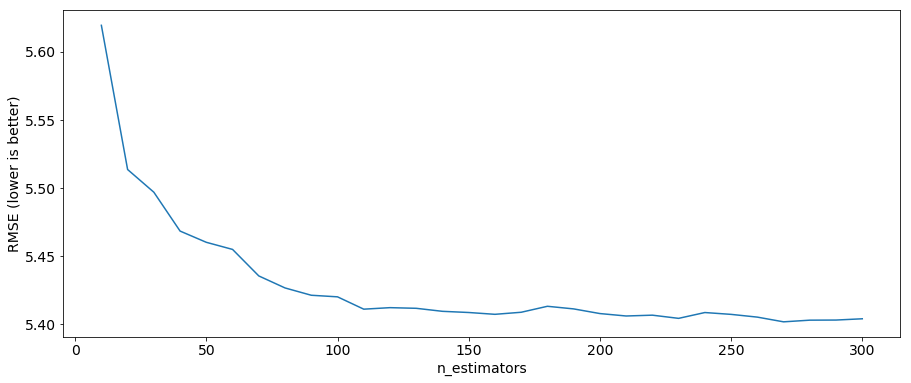

In [146]:
# Plot RMSE (y-axis) versus n_estimators (x-axis).

plt.plot(estimator_range, RMSE_scores);

plt.xlabel('n_estimators');
plt.ylabel('RMSE (lower is better)');

In [147]:
# Show the best RMSE and the corresponding max_features.
sorted(zip(RMSE_scores, estimator_range))[0]

(5.401934373330385, 270)

Based from the results, we should set n_estimators to be 270.

#### 2.Tuning max_features: 

In [148]:
feature_range = list(range(1,len(feature_cols)+1))

#List to store the average RMSE for each value of max_feature:
RMSE_scores = []

#Use five-fold cross-validation with each value of max_feature:
for feature in feature_range:
    rfreg = RandomForestRegressor(n_estimators=150, max_features=feature, random_state=1)
    MSE_scores = cross_val_score(rfreg, X, y, cv=5, scoring = 'neg_mean_squared_error')
    RMSE_scores.append(np.mean(np.sqrt(-MSE_scores)))

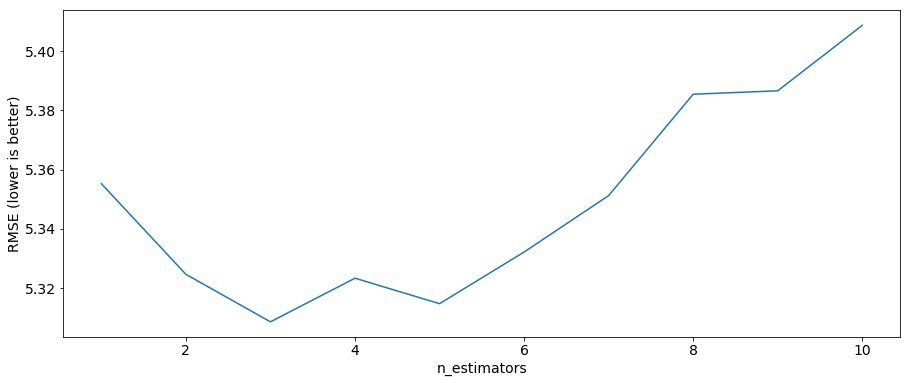

In [150]:
# Plot RMSE (y-axis) versus n_estimators (x-axis).

plt.plot(feature_range, RMSE_scores);

plt.xlabel('n_estimators');
plt.ylabel('RMSE (lower is better)');

In [151]:
sorted(zip(RMSE_scores, feature_range))[0]

(5.308553368905247, 3)

Seems like 3 is the ideal number of estimators we can have.<br>
Another note is that our RMSE for Random Forest is significantly lower than the RMSE for Linear Regression.

#### *Again, predict Stephen Curry's salary!*

In [155]:
rfreg = RandomForestRegressor(n_estimators=20, max_features=3, oob_score=True, random_state=1)
rfreg.fit(X, y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=3, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=20, n_jobs=None, oob_score=True, random_state=1,
           verbose=0, warm_start=False)

In [156]:
steph_pred = rfreg.predict(steph_test.reshape(1,-1))
print('Through Random Forest Regression, predicted Salary for Stephen Curry is {} million USD.'.format(round(steph_pred[0],2)))

Through Random Forest Regression, predicted Salary for Stephen Curry is 30.25 million USD.


### 3. Predicting Salary with XGBoost
<a id="XGBoost-regression"></a>

#### Preliminary XGBoost Model

Create a Data Matrix, and initiate the XGBRegressor object.

In [163]:
data_dmatrix = xgb.DMatrix(data=X,label=y)

In [164]:
xgbr = XGBRegressor(verbosity=0,objective='reg:linear',colsample_bytree=0.3, learning_rate=0.1, max_depth=5, n_estimators=10)
xgbr.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.3, gamma=0,
       importance_type='gain', learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=10,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=0)

In [168]:
preds = xgbr.predict(X_test)

In [169]:
rmse = np.sqrt(metrics.mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))

RMSE: 6.800154


Our RMSE is considerably low, as the Random Forest Regression Model.

#### 5-fold cross validation using the CV method.

In [170]:
params = {"objective":"reg:linear",'colsample_bytree': 0.3,'learning_rate': 0.1,
                'max_depth': 5}

cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=5,
                    num_boost_round=100,metrics="rmse", as_pandas=True, seed=123)

[00:17:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:17:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:17:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:17:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:17:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [84]:
cv_results.head()

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,10.404860,0.056239,10.451589,0.235509
1,9.666683,0.049044,9.733226,0.234482
2,9.059017,0.066598,9.173533,0.254345
3,8.519175,0.059094,8.664671,0.264086
4,8.057265,0.051878,8.250037,0.282010


In [172]:
print(cv_results["test-rmse-mean"].tail(1))

99    5.430284
Name: test-rmse-mean, dtype: float64


#### Note: This is our final RMSE-mean after boosting/learning 100 times, which is lower than our Preliminary Model. 

#### Now, we find Find the feature importance for the XGBR Model.

xgb.plot_importance(xgbr)
plt.rcParams['figure.figsize'] = [5, 5]
plt.show()

#### *Again, we predict Steph's Salary!*

In [182]:
steph_test
steph_df=pd.DataFrame(steph_test,columns=feature_cols)

In [190]:
steph_pred = xgbr.predict(steph_df)
steph_pred = round(steph_pred[0],2)
print('Through XGBoost Regression, predicted Salary for Stephen Curry is {} million USD.'.format(steph_pred))

Through XGBoost Regression, predicted Salary for Stephen Curry is 17.290000915527344 million USD.


<a id="conclusion"></a>
## Conclusion

- Random Forest seems to be the best model we have, as it is the one closest to Steph Curry's salary of 40 million USD.
- It also has a very low RMSE, along XGBoost.
- Improvements could be made:
    - Salary (target data) distribution could be an exponential graph, so perhaps it would be better if we transform    it with Ln first